# Analysing the calibration of the ConvNext_BS model on BirdSet

In [33]:
# Load predictions from each test set by looping over all folders in /workspace/logs/predictions/convnext_bs and load the .pkl files

# load data in dict form: data[<dataset_name>] = (predictions, targets, metadata)
import os
import torch
from matplotlib import pyplot as plt
from uncertainbird.utils.misc import load_dump

data = {}

log_dir = "/workspace/logs/predictions/convnext_bs"
dataset_names = sorted(
    [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
)

# colormap without red (tab10 index 3 is red)
colors = plt.cm.tab10
skip_index = 3
available_indices = [i for i in range(colors.N) if i != skip_index]
dataset_colors = {}

for i, ds in enumerate(dataset_names):
    data[ds] = {}
    color_idx = available_indices[i % len(available_indices)]
    dataset_colors[ds] = colors(color_idx)

    ds_path = os.path.join(log_dir, ds)
    pkl_files = [f for f in os.listdir(ds_path) if f.endswith(".pkl")]
    if not pkl_files:
        continue
    # pick most recent file
    pkl_files.sort(
        key=lambda f: os.path.getmtime(os.path.join(ds_path, f)), reverse=True
    )
    file_path = os.path.join(ds_path, pkl_files[0])
    preds, t, metadata = load_dump(file_path)
    data[ds]["predictions"] = preds
    data[ds]["targets"] = t.int()
    data[ds]["metadata"] = metadata
    data[ds]["color"] = dataset_colors[ds]

# concatenate
predictions = torch.cat([data[k]["predictions"] for k in data], dim=0)
targets = torch.cat([data[k]["targets"] for k in data], dim=0)

predictions.shape, targets.shape

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilab

KeyError: 'predictions'

## Global - all labels incl. non present target labels

In [2]:
from uncertainbird.utils.plotting import print_metrics

metrics = print_metrics(predictions, targets)

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This m

Accuracy: tensor(0.9999)
cmAP: tensor(0.2256)
Precision: tensor(0.0156)
Recall: tensor(0.0035)
F1 Score: tensor(0.0047)
AUROC: tensor(0.0353)
ECE: tensor(0.0002)
ECE Weighted: tensor(0.0233)
ECE Top-3: tensor(0.0642)
ECE Top-5: tensor(0.0490)
ECE Top-10: tensor(0.0365)
ECE Top-21: tensor(0.0255)


<Axes: title={'center': 'Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = 2.33%'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

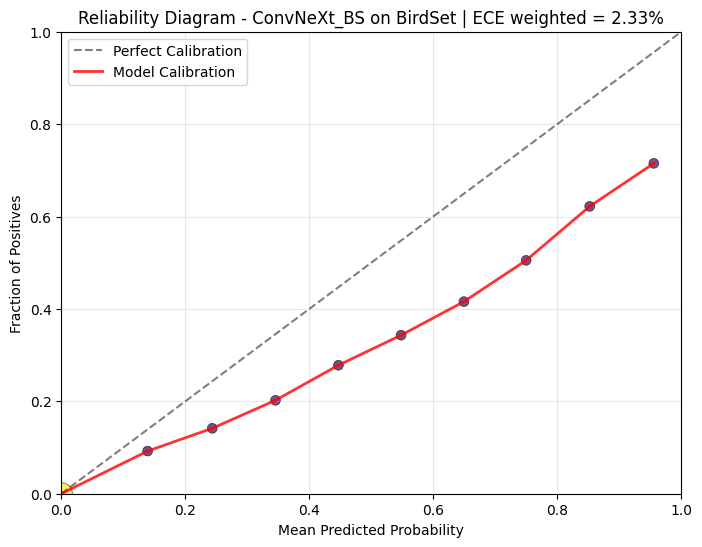

In [3]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions,
    targets,
    n_bins=10,
    title=f"Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = {metrics['ece_weighted']*100:.2f}%",
)

## Globael - only classes present in the target labels

```python

In [20]:
# how many classes are represented by atleast one sample in the targets?
print("Number of classes in targets:", targets.sum(dim=0).gt(0).sum().item())
# how many classes are represented by atleast 5 samples in the targets?
print(
    "Number of classes with atleast 5 samples in targets:",
    targets.sum(dim=0).ge(5).sum().item(),
)

Number of classes in targets: 383
Number of classes with atleast 5 samples in targets: 334


In [21]:
# select only target classes
predictions_targetclasses = predictions[:, targets.sum(dim=0).gt(0)]
targets_targetclasses = targets[:, targets.sum(dim=0).gt(0)]

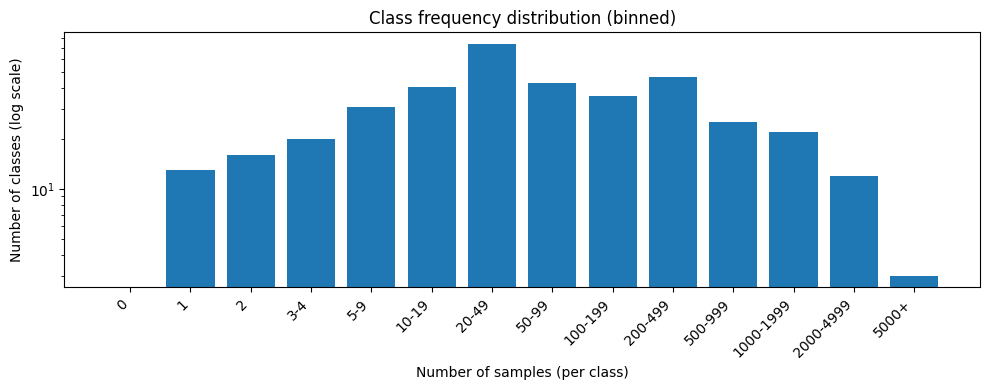

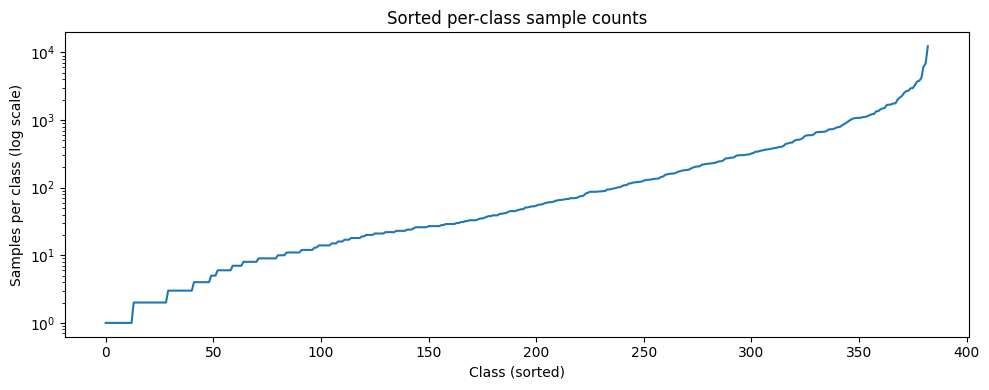

In [22]:
from uncertainbird.utils.plotting import plot_class_frequency

plot_class_frequency(targets_targetclasses)

In [23]:
from uncertainbird.utils.plotting import print_metrics

metrics_targetclasses = print_metrics(predictions_targetclasses, targets_targetclasses)

Accuracy: tensor(0.9972)
cmAP: tensor(0.2256)
Precision: tensor(0.3963)
Recall: tensor(0.0884)
F1 Score: tensor(0.1202)
AUROC: tensor(0.8968)
ECE: tensor(0.0027)
ECE Weighted: tensor(0.0233)
ECE Top-3: tensor(0.0642)
ECE Top-5: tensor(0.0490)
ECE Top-10: tensor(0.0365)
ECE Top-21: tensor(0.0255)


<Axes: title={'center': 'Reliability Diagram - ConvNeXt-BS on BirdSet'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

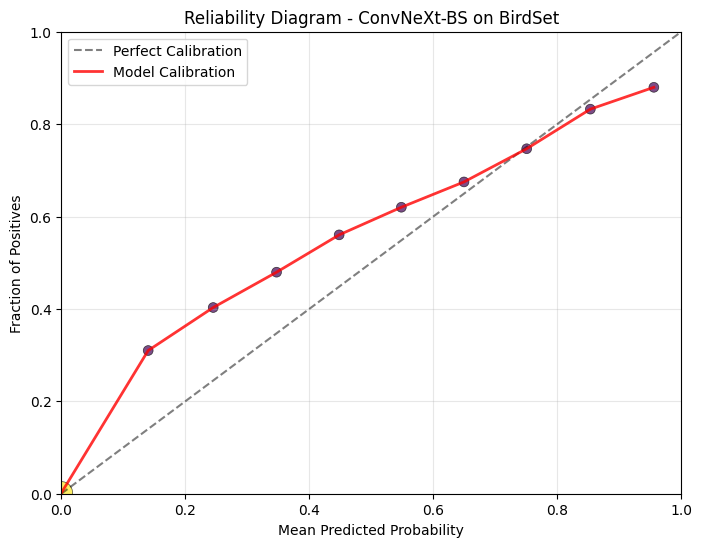

In [ ]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions_targetclasses,
    targets_targetclasses,
    n_bins=10,
    title=f"Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = {metrics_targetclasses['ece_weighted']*100:.2f}%",
)

## Class-wise Calibration Plots

In [30]:
# only select classes with target labels
for key in data:
    data[key] = (
        data[key][0][:, targets.sum(dim=0).gt(0)],
        data[key][1][:, targets.sum(dim=0).gt(0)],
        data[key][2],
    )

In [29]:
# compute metrics
for key in data:
    print("Computing metrics for", key)
    entry = data[key]
    if isinstance(entry, tuple):
        preds_ds, targets_ds, meta = entry
        data[key] = {0: preds_ds, 1: targets_ds, 2: meta}
    else:
        preds_ds, targets_ds = entry[0], entry[1]
    data[key]["metrics"] = print_metrics(data[key][0], data[key][1])

Computing metrics for HSN


KeyboardInterrupt: 

### Reliability Diagram
```

#### Combined

<Axes: title={'center': 'Combined Reliability Diagram - ConvNeXt_BS on BirdSet'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

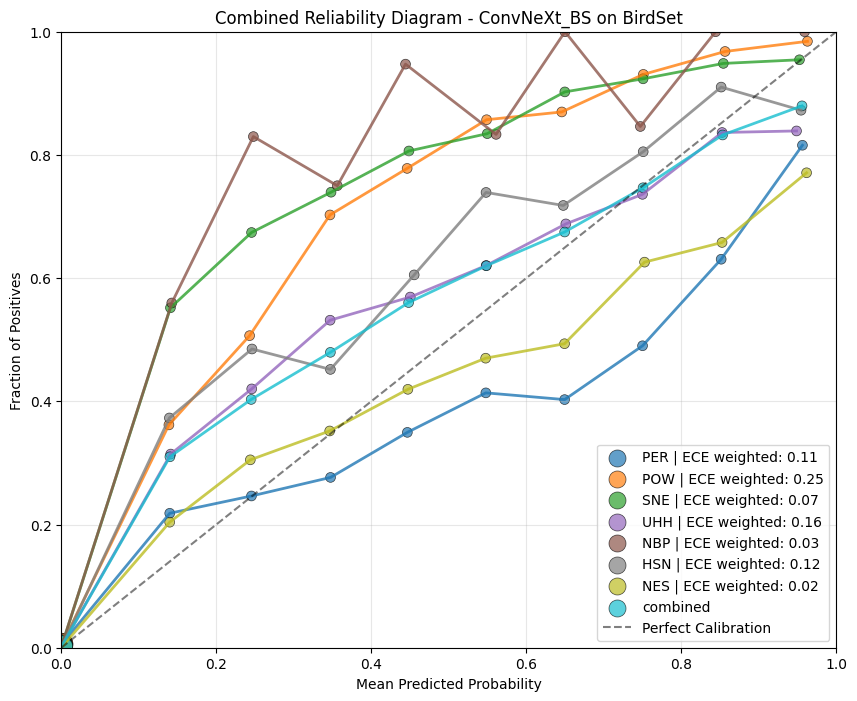

In [25]:
from uncertainbird.utils.plotting import plot_combined_reliability_diagram

# add average / combined data of all datasets
data["combined"] = (
    predictions_targetclasses,
    targets_targetclasses,
    None,
    metrics_targetclasses,
)

plot_combined_reliability_diagram(
    data, n_bins=10, title="Combined Reliability Diagram - ConvNeXt_BS on BirdSet"
)

#### Per class

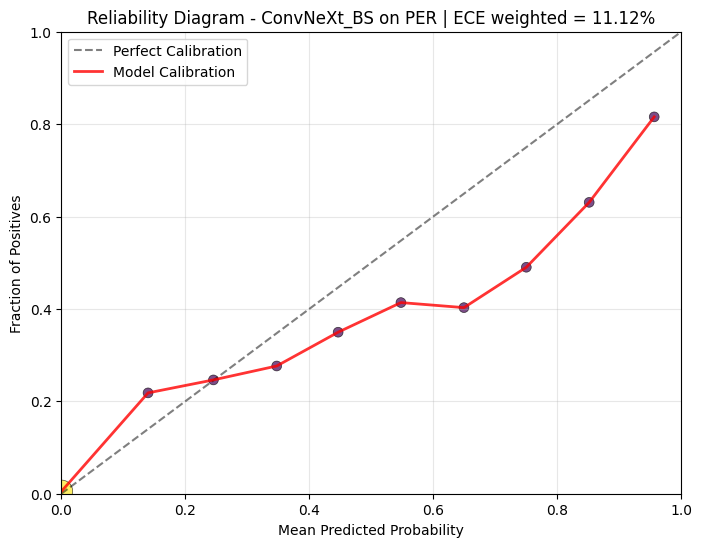

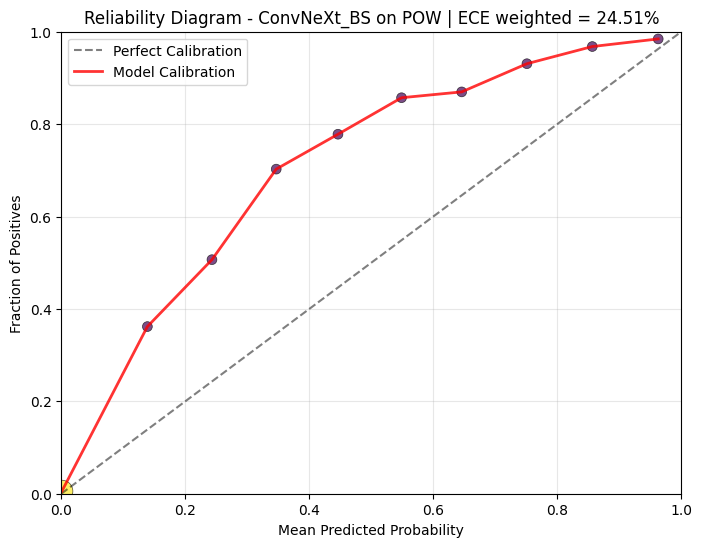

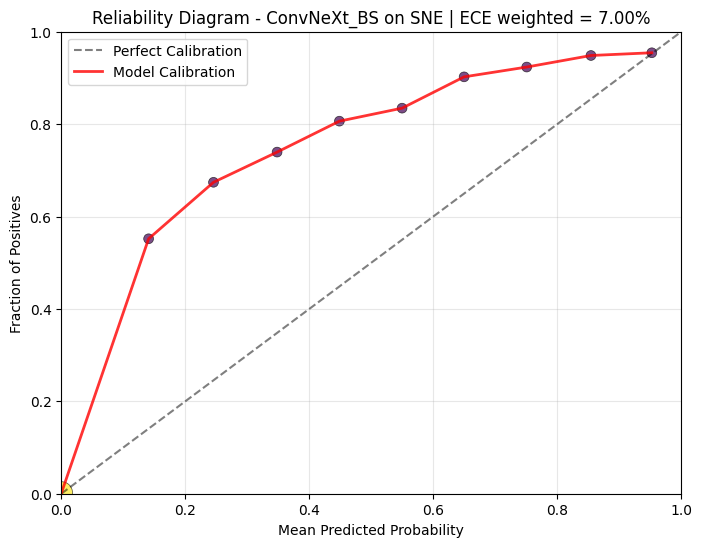

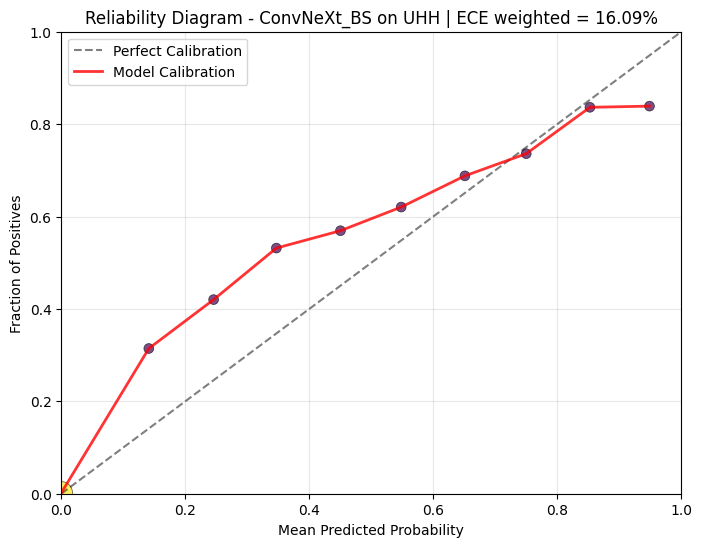

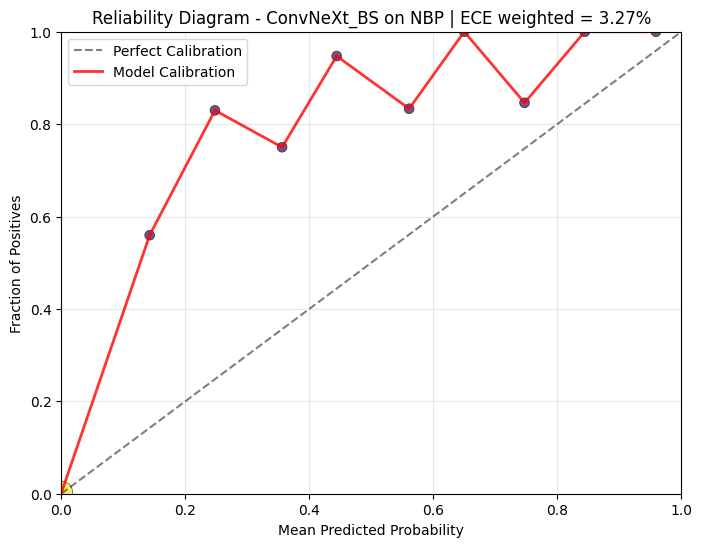

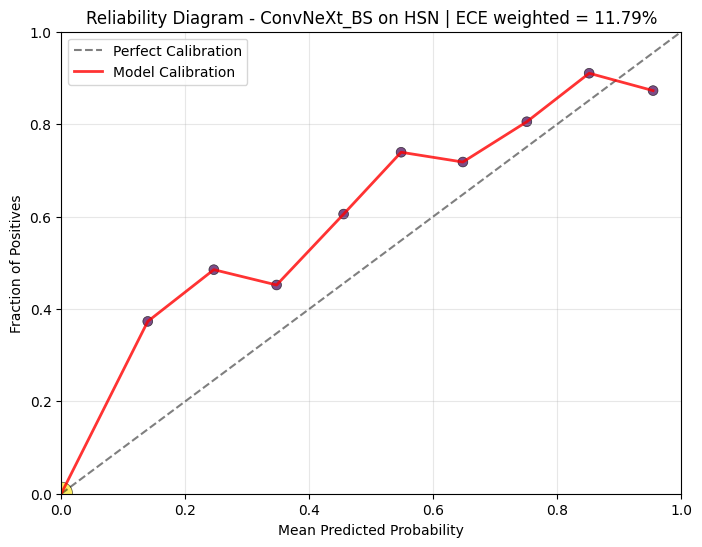

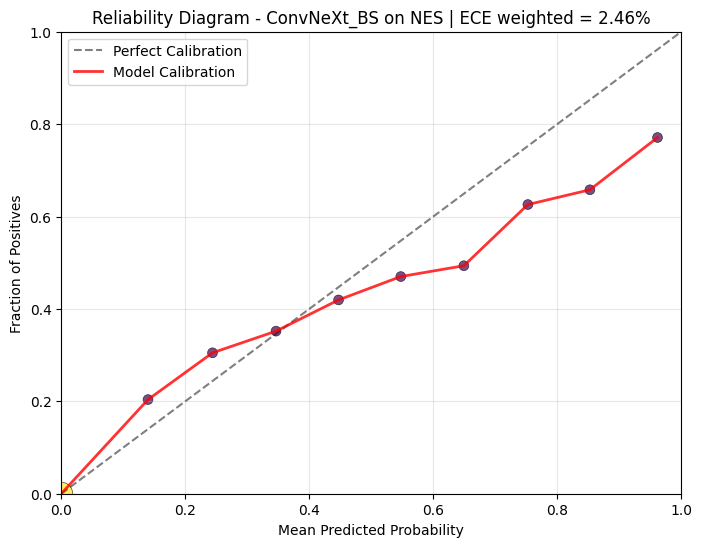

In [15]:
for key in data:
    plot_reliability_diagram(
        data[key][0],
        data[key][1],
        n_bins=10,
        title=f"Reliability Diagram - ConvNeXt_BS on {key} | ECE weighted = {data[key]['metrics']['ece_weighted']*100:.2f}%",
    )

In [20]:
from uncertainbird.utils.misc import class_wise_statistics

class_stats = class_wise_statistics(predictions, targets, n_bins=10)

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  indices = torch.bucketize(confidences, bin_boundaries, right=True) - 1


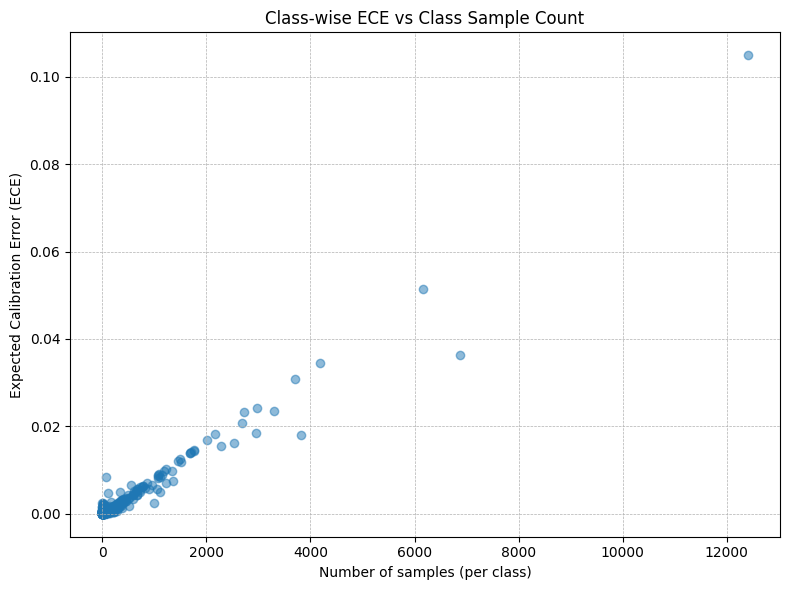

In [22]:
# plot ece vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["ece"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("Expected Calibration Error (ECE)")
plt.title("Class-wise ECE vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

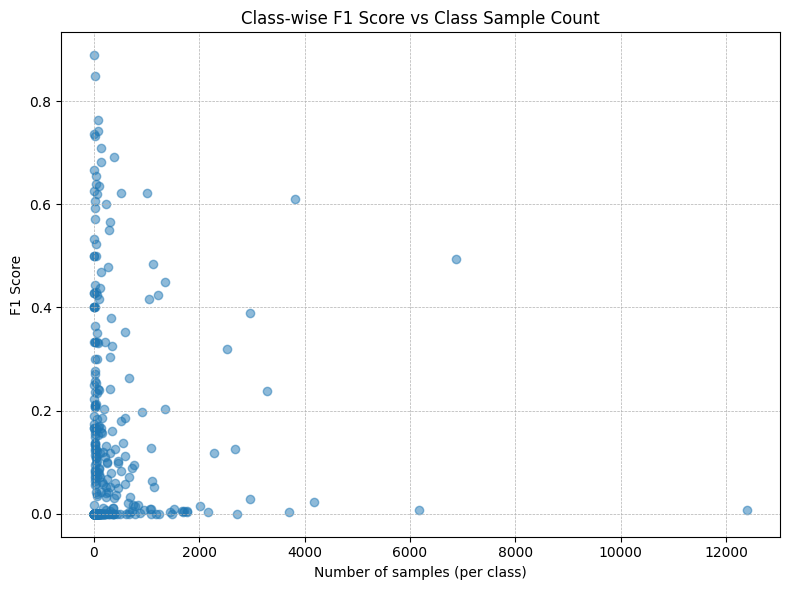

In [23]:
# f1 vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["f1_score"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Score vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()

## Dataset wise statistics

### HSN

In [ ]:
# load dump
log_dir = "/workspace/logs/predictions/convnext_bs/HSN"
file = 
predictions, targets, metadata = load_dump(os.path.join(log_dir, "predictions.pkl"))

In [7]:
# how many classes are represented by atleast one prediction with prob > 0.5 that are not in the targets?
predictions_gt_05 = predictions.gt(0.5)
classes_in_predictions_gt_05 = predictions_gt_05.sum(dim=0).gt(0)
classes_in_targets = targets.sum(dim=0).gt(0)
classes_in_predictions_not_in_targets = (
    classes_in_predictions_gt_05 & ~classes_in_targets
)
print(
    "Number of classes in predictions with prob > 0.5 that are not in targets:",
    classes_in_predictions_not_in_targets.sum().item(),
)

Number of classes in predictions with prob > 0.5 that are not in targets: 764
